In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


In [2]:
df = pd.read_csv('raw_data/precision-experiment-2022-11-09T14_30_34.775Z (2).csv')
df.head(5)

,rt,response,trial_type,trial_index,time_elapsed,internal_node_id,load_time,success,jspsych_start_time,item_width_mm,item_height_mm,item_width_px,px2mm,view_dist_mm,item_width_deg,px2deg,win_width_deg,win_height_deg,stimulus,response_type,key_press,avg_frame_time,center_x,center_y,rastoc-type,stimulus-coordinate,calibration-id,calibration-point-id,inner-width,inner-height,webgazer_data,webgazer_targets,session-id,validation-id,tracked-trial-id,trial-tag,start-x,start-y,events
0,30224.0,"{""webcam-id"":""3"",""computer-id"":""3"",""web-browse...",survey-html-form,0,30228,0.0-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,webgazer-init-camera,1,46985,0.0-1.0,1831.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,fullscreen,2,50819,0.0-2.0,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,events-tracking-start,3,50820,0.0-3.0,NaN,NaN,2022-11-09T14:15:44.293Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,86535.0,NaN,virtual-chinrest,4,137356,0.0-4.0,NaN,NaN,NaN,85.6,53.98,344.0,4.02,586.22,8.351527,41.190073,46.613173,26.21991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
df.columns

Index(['rt', 'response', 'trial_type', 'trial_index', 'time_elapsed',
       'internal_node_id', 'load_time', 'success', 'jspsych_start_time',
       'item_width_mm', 'item_height_mm', 'item_width_px', 'px2mm',
       'view_dist_mm', 'item_width_deg', 'px2deg', 'win_width_deg',
       'win_height_deg', 'stimulus', 'response_type', 'key_press',
       'avg_frame_time', 'center_x', 'center_y', 'rastoc-type',
       'stimulus-coordinate', 'calibration-id', 'calibration-point-id',
       'inner-width', 'inner-height', 'webgazer_data', 'webgazer_targets',
       'session-id', 'validation-id', 'tracked-trial-id', 'trial-tag',
       'start-x', 'start-y', 'events'],
      dtype='object')

In [44]:
# Tenemos 
df['trial-tag'].value_counts(dropna=False)

validation-stimulus    576
NaN                    167
fixation-stimulus       64
Name: trial-tag, dtype: int64

In [64]:
df['stimulus-coordinate'].value_counts(dropna=False)

NaN                    663
{"x":412,"y":0}         16
{"x":0,"y":-405}        16
{"x":412,"y":-405}      16
{"x":0,"y":0}           16
{"x":-412,"y":-405}     16
{"x":0,"y":405}         16
{"x":-412,"y":0}        16
{"x":412,"y":405}       16
{"x":-412,"y":405}      16
Name: stimulus-coordinate, dtype: int64

In [76]:
df['stimulus'].value_counts()

\n        <h3>Calibration Session</h3>\n\n        Sit comfortably, from now on try to keep your head as still as\n        possible.\n        <br>\n        <br>\n        \n        Next you will see a <b>series of markers</b> in the screen.\n        <br>\n\n        As they appear <b>fix your gaze</b> on them.\n        <br>\n\n        Once they turn orange, press the <b>space bar</b>.\n        <br>\n                8
\n      <h3>Experimentation Session (1 / 8)</h3>\n      8 times you will see a series of stimulus in the same\n      positions in which you just calibrated.\n      Fix your gaze on them as they appear.\n      <br>\n\n      A central cross will appear in between each pair of series.\n      While this cross is present you can rest your gaze and blink.\n      <br>\n\n      Press the space bar to start.\n            1
\n      <h3>Experimentation Session (2 / 8)</h3>\n      8 times you will see a series of stimulus in the same\n      positions in which you just calibrated.\n      

In [ ]:
for i in df.columns:
    print('columna: ',i)
    print(' ')
    print(df[i].value_counts())
    print(' ')

In [78]:
df['stimulus-coordinate'].value_counts(dropna=False)

NaN                    663
{"x":412,"y":0}         16
{"x":0,"y":-405}        16
{"x":412,"y":-405}      16
{"x":0,"y":0}           16
{"x":-412,"y":-405}     16
{"x":0,"y":405}         16
{"x":-412,"y":0}        16
{"x":412,"y":405}       16
{"x":-412,"y":405}      16
Name: stimulus-coordinate, dtype: int64

<function matplotlib.pyplot.xlim(*args, **kwargs)>

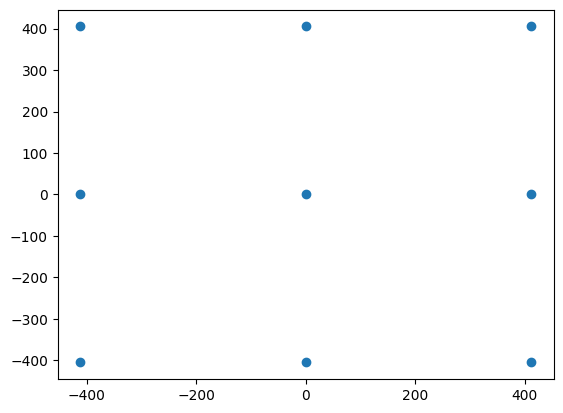

In [92]:
coords = df[~df['stimulus-coordinate'].isna()].iloc[:9]['stimulus-coordinate'].map(eval)
xs = []
ys = []
for i in coords:
    xs.append(i['x'])
    ys.append(i['y'])

plt.scatter(xs,ys)
plt.xlim

In [50]:
df[df['trial-tag'] == 'validation-stimulus']['webgazer_data']

26     [{"x":1189,"y":494,"t":0},{"x":1101,"y":478,"t...
27     [{"x":1148,"y":493,"t":0},{"x":1119,"y":451,"t...
28     [{"x":1248,"y":743,"t":0},{"x":1296,"y":731,"t...
29     [{"x":469,"y":191,"t":0},{"x":500,"y":178,"t":...
30     [{"x":1188,"y":322,"t":0},{"x":1164,"y":292,"t...
                             ...                        
800    [{"x":959,"y":899,"t":0},{"x":972,"y":779,"t":...
801    [{"x":1439,"y":466,"t":0},{"x":1347,"y":445,"t...
802    [{"x":499,"y":820,"t":0},{"x":504,"y":741,"t":...
803    [{"x":539,"y":139,"t":0},{"x":531,"y":141,"t":...
804    [{"x":1313,"y":694,"t":0},{"x":1326,"y":680,"t...
Name: webgazer_data, Length: 576, dtype: object

In [ ]:
df[~df['webgazer_data'].isna()]

In [ ]:
# for d in df[~df['webgazer_data'].isna()]['webgazer_data'].map(eval):
TAG = 'fixation-stimulus' # Es el momento donde aparece la cruz de fijacion

k = 0
plt.vlines(960,0,1080,'k')
plt.hlines(540,0,1920,'k')
for d in df[df['trial-tag'] == TAG]['webgazer_data'].map(eval):
    n = sum(df['trial-tag'] == TAG)
    xs = []
    ys = []
    ts = []
    for i in d:
        xs.append(i['x'])
        ys.append(i['y'])
        ts.append(i['t'])
    
    plt.scatter(xs,ys,c=(k/n)*np.reshape(np.repeat(np.ones(len(xs)),3),(len(xs),3)))
    k+=1

plt.xlim(0, 1920)
plt.ylim(0, 1080)
plt.show()

Validation point (1): 960, 536
Time between samples (ms) = 48 +- 14 
Sampling rate (Hz) = 26 +- 28 
Last time sample = 2018
Horizontal error (pxs) = 194 +- 71 
Vertical error (pxs) = 57 +- 45 
Total error (pxs) = 208 +- 69 


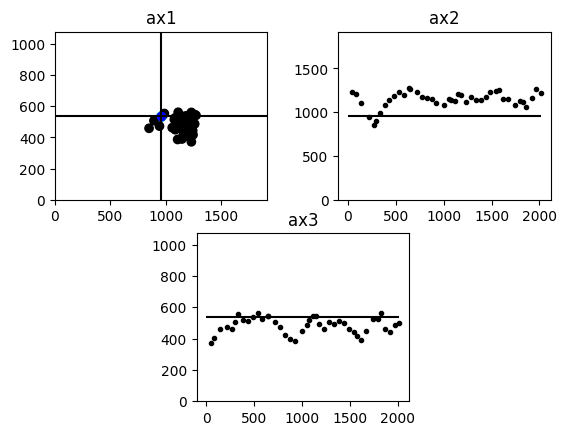

Validation point (2): 960, 536
Time between samples (ms) = 50 +- 14 
Sampling rate (Hz) = 23 +- 13 
Last time sample = 2018
Horizontal error (pxs) = 257 +- 106 
Vertical error (pxs) = 195 +- 134 
Total error (pxs) = 332 +- 152 


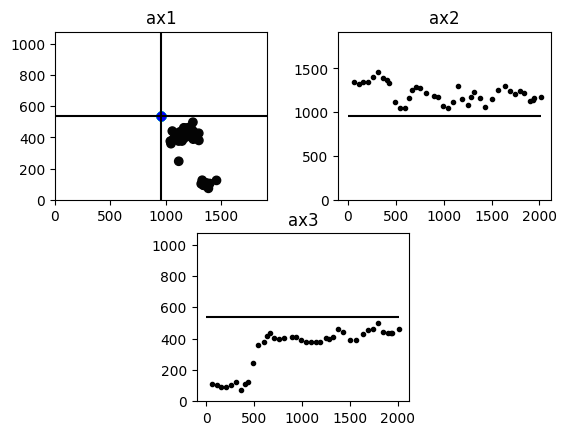

Validation point (3): 960, 536
Time between samples (ms) = 47 +- 11 
Sampling rate (Hz) = 23 +- 6 
Last time sample = 2011
Horizontal error (pxs) = 219 +- 114 
Vertical error (pxs) = 136 +- 98 
Total error (pxs) = 266 +- 137 


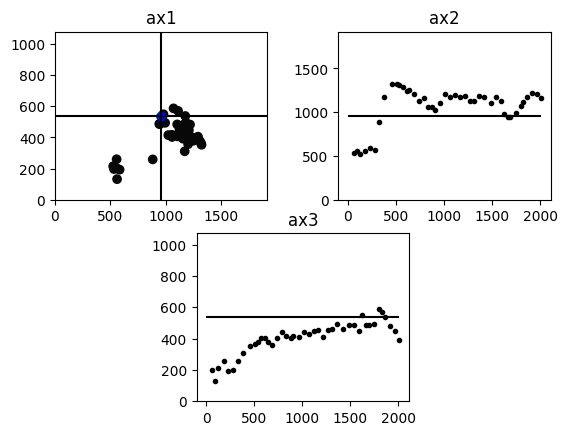

Validation point (4): 960, 536
Time between samples (ms) = 45 +- 10 
Sampling rate (Hz) = 23 +- 6 
Last time sample = 1998
Horizontal error (pxs) = 261 +- 73 
Vertical error (pxs) = 141 +- 70 
Total error (pxs) = 302 +- 83 


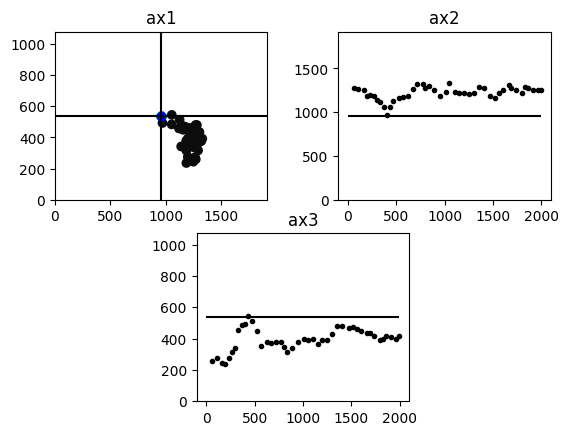

Validation point (5): 960, 536
Time between samples (ms) = 48 +- 10 
Sampling rate (Hz) = 22 +- 6 
Last time sample = 2010
Horizontal error (pxs) = 268 +- 143 
Vertical error (pxs) = 120 +- 41 
Total error (pxs) = 299 +- 138 


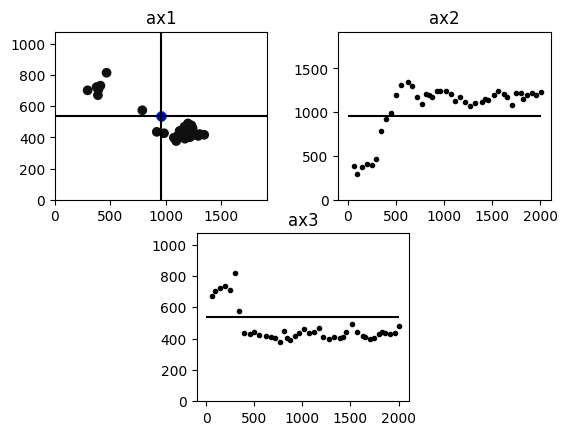

Validation point (6): 960, 536
Time between samples (ms) = 50 +- 12 
Sampling rate (Hz) = 22 +- 6 
Last time sample = 1982
Horizontal error (pxs) = 263 +- 125 
Vertical error (pxs) = 138 +- 49 
Total error (pxs) = 301 +- 124 


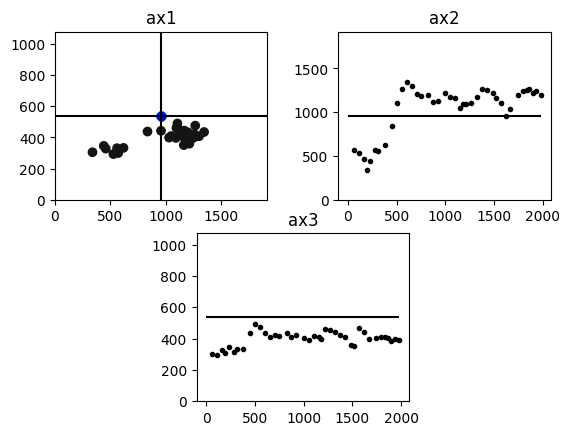

Validation point (7): 960, 536
Time between samples (ms) = 48 +- 11 
Sampling rate (Hz) = 22 +- 6 
Last time sample = 1998
Horizontal error (pxs) = 235 +- 85 
Vertical error (pxs) = 120 +- 56 
Total error (pxs) = 269 +- 87 


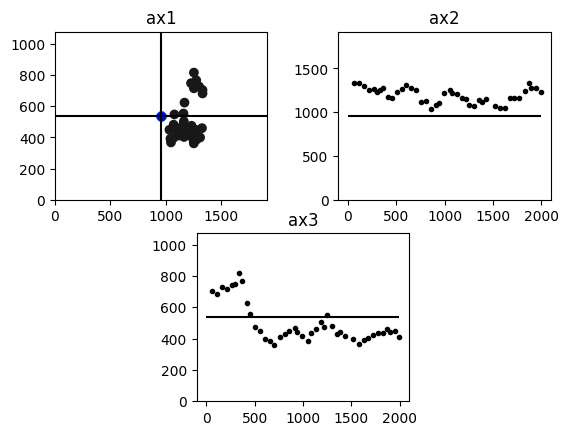

Validation point (8): 960, 536
Time between samples (ms) = 47 +- 10 
Sampling rate (Hz) = 22 +- 5 
Last time sample = 2012
Horizontal error (pxs) = 296 +- 111 
Vertical error (pxs) = 114 +- 54 
Total error (pxs) = 321 +- 115 


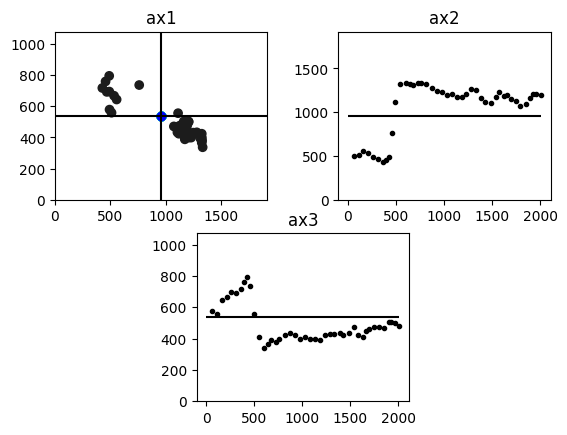

Validation point (9): 960, 536
Time between samples (ms) = 49 +- 13 
Sampling rate (Hz) = 25 +- 28 
Last time sample = 2018
Horizontal error (pxs) = 101 +- 78 
Vertical error (pxs) = 41 +- 27 
Total error (pxs) = 119 +- 67 


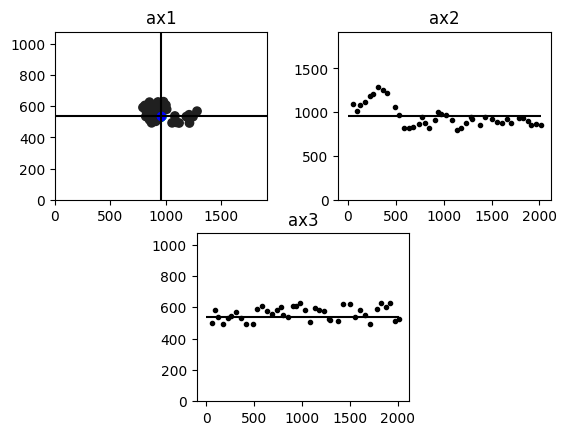

Validation point (10): 960, 536
Time between samples (ms) = 48 +- 10 
Sampling rate (Hz) = 22 +- 5 
Last time sample = 1982
Horizontal error (pxs) = 133 +- 138 
Vertical error (pxs) = 106 +- 98 
Total error (pxs) = 193 +- 143 


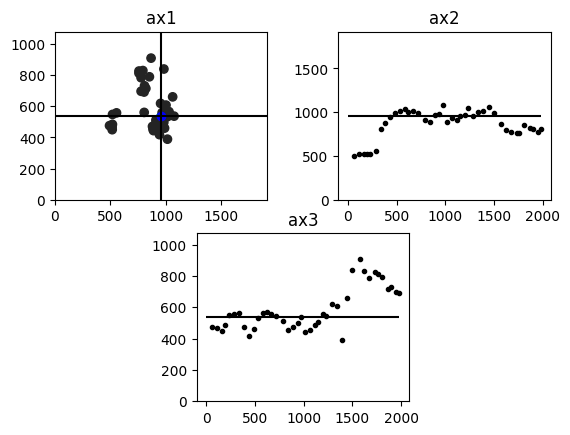

Validation point (11): 960, 536
Time between samples (ms) = 46 +- 12 
Sampling rate (Hz) = 23 +- 7 
Last time sample = 1983
Horizontal error (pxs) = 66 +- 51 
Vertical error (pxs) = 115 +- 124 
Total error (pxs) = 152 +- 113 


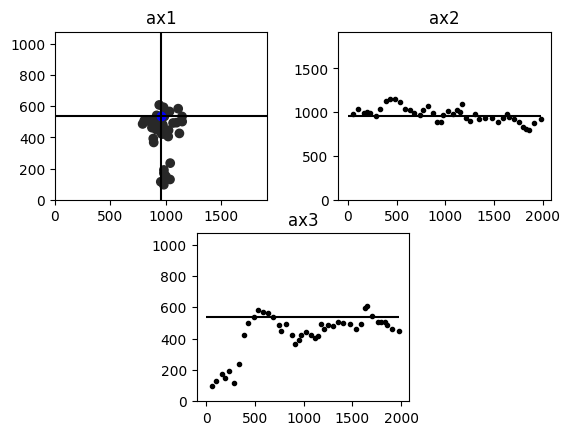

,trials,presented_point,time_between_samples_mean,time_between_samples_std,sampling_rate_mean,sampling_rate_std,last_time_sample,horizontal_errors_pxs_mean,horizontal_errors_pxs_std,vertical_errors_pxs_mean,vertical_errors_pxs_std,total_errors_pxs_mean,total_errors_pxs_std
0,1.0,"(960.0, 536.0)",48.121951,14.102750,26.113570,28.128464,2018,194.452381,71.196309,56.595238,45.055553,208.057950,69.466223
1,2.0,"(960.0, 536.0)",50.450000,13.564568,22.541669,13.373138,2018,256.550000,105.863107,195.050000,133.711621,331.585257,151.655587
2,3.0,"(960.0, 536.0)",46.767442,10.728873,22.706890,6.014931,2011,219.186047,114.314998,135.930233,98.115593,265.607431,136.626616
3,4.0,"(960.0, 536.0)",45.409091,10.451877,23.361389,5.970426,1998,260.545455,73.290969,140.659091,69.872268,301.714934,83.010313
4,5.0,"(960.0, 536.0)",47.857143,10.269167,22.065597,5.637981,2010,268.333333,143.331728,119.714286,41.496004,299.298859,137.914406
5,6.0,"(960.0, 536.0)",49.550000,12.271817,21.544170,5.838596,1982,262.725000,125.148909,137.600000,48.686651,300.952493,124.170938
6,7.0,"(960.0, 536.0)",47.571429,11.345532,22.400044,6.199642,1998,234.785714,85.160782,119.666667,55.763389,268.758252,87.036539
7,8.0,"(960.0, 536.0)",46.790698,9.537096,22.465189,5.467995,2012,296.162791,111.332298,114.372093,53.715886,320.830010,114.637498
8,9.0,"(960.0, 536.0)",49.219512,13.455459,25.335862,28.079089,2018,101.073171,77.953517,41.487805,27.056510,119.181320,67.391707
9,10.0,"(960.0, 536.0)",48.341463,10.158764,21.796661,5.481912,1982,133.390244,138.237667,105.926829,98.152542,193.131154,143.029304


In [3]:
def calculate_and_plot_errors(
    df, TRIAL_TAG, first_sample=0, max_plots=5, screen_res=(1920, 1080)
):
    """_summary_

    Args:
        df (Pandas DataFrame): Data
        TRIAL_TAG (str): Type of trial (`validation-stimulus` or `fixation-stimulus`)
        first_sample (int, optional): First sample fo evaluate. Useful for filtering. Defaults to 0.
        max_plots (int, optional): Max number of plots. Defaults to 5.
        screen_res (tuple, optional): Screen Resolution of experiment. Defaults to (1920, 1080).

    Returns:
        pd.DataFrame: Analyzed data with columns:
            "trials": trials
            "presented_point": presented_points
            "time_between_samples_mean": time_between_samples_mean
            "time_between_samples_std": time_between_samples_std
            "sampling_rate_mean": sampling_rate_mean
            "sampling_rate_std": sampling_rate_std
            "last_time_sample": last_time_sample
            "horizontal_errors_pxs_mean": horizontal_errors_pxs_mean,
            "horizontal_errors_pxs_std": horizontal_errors_pxs_std,
            "vertical_errors_pxs_mean": vertical_errors_pxs_mean,
            "vertical_errors_pxs_std": vertical_errors_pxs_std,
            "total_errors_pxs_mean": total_errors_pxs_mean,
            "total_errors_pxs_std": total_errors_pxs_std
    """
    trials = []
    presented_points = []
    time_between_samples_mean = []
    time_between_samples_std = []
    sampling_rate_mean = []
    sampling_rate_std = []
    last_time_sample = []
    horizontal_errors_pxs_mean = []
    horizontal_errors_pxs_std = []
    vertical_errors_pxs_mean = []
    vertical_errors_pxs_std = []
    total_errors_pxs_mean = []
    total_errors_pxs_std = []

    center_x = df[df["trial-tag"] == TRIAL_TAG]["center_x"].iloc[0]
    center_y = df[df["trial-tag"] == TRIAL_TAG]["center_y"].iloc[0]

    n = sum(df["trial-tag"] == TRIAL_TAG)

    nv = df[df["trial-tag"] == TRIAL_TAG]["validation-id"].values
    xv = df[df["trial-tag"] == TRIAL_TAG]["start-x"].values + center_x
    yv = df[df["trial-tag"] == TRIAL_TAG]["start-y"].values + center_y

    first_sample = 0
    k = 0
    for d in df[df["trial-tag"] == TRIAL_TAG]["webgazer_data"].map(eval):
        xs = []
        ys = []
        ts = []
        for i in d:
            xs.append(i["x"])
            ys.append(i["y"])
            ts.append(i["t"])

        trials.append(nv[k])
        presented_points.append((xv[k], yv[k]))
        time_between_samples_mean.append(np.mean(np.diff(ts)))
        time_between_samples_std.append(np.std(np.diff(ts)))
        sampling_rate_mean.append(np.mean(1000 / np.diff(ts)))
        sampling_rate_std.append(np.std(1000 / np.diff(ts)))
        last_time_sample.append(max(ts))
        print("Validation point (%d): %d, %d" % (nv[k], xv[k], yv[k]))
        print(
            "Time between samples (ms) = %.0f +- %.0f "
            % (np.mean(np.diff(ts)), np.std(np.diff(ts)))
        )
        print(
            "Sampling rate (Hz) = %.0f +- %.0f "
            % (np.mean(1000 / np.diff(ts)), np.std(1000 / np.diff(ts)))
        )
        print("Last time sample = %d" % max(ts))

        xs = np.array(xs)
        ys = np.array(ys)
        ts = np.array(ts)

        xs = xs[ts > first_sample]
        ys = ys[ts > first_sample]
        ts = ts[ts > first_sample]

        ex = abs(xs - xv[k])
        ey = abs(ys - yv[k])
        ee = np.sqrt(ex**2 + ey**2)

        horizontal_errors_pxs_mean.append(np.mean(ex))
        horizontal_errors_pxs_std.append(np.std(ex))
        vertical_errors_pxs_mean.append(np.mean(ey))
        vertical_errors_pxs_std.append(np.std(ey))
        total_errors_pxs_mean.append(np.mean(ee))
        total_errors_pxs_std.append(np.std(ee))
        print("Horizontal error (pxs) = %.0f +- %.0f " % (np.mean(ex), np.std(ex)))
        print("Vertical error (pxs) = %.0f +- %.0f " % (np.mean(ey), np.std(ey)))
        print("Total error (pxs) = %.0f +- %.0f " % (np.mean(ee), np.std(ee)))

        gs = gridspec.GridSpec(2, 4)
        gs.update(wspace=1)
        ax1 = plt.subplot(gs[0, :2], )
        ax1.set_title('ax1')

        ax2 = plt.subplot(gs[0, 2:])
        ax2.set_title('ax2')

        ax3 = plt.subplot(gs[1, 1:3])
        ax3.set_title('ax3')

        ax1.scatter(xv, yv, c="c")
        ax1.vlines(screen_res[0] / 2, 0, screen_res[1], "k")
        ax1.hlines(screen_res[1] / 2, 0, screen_res[0], "k")
        ax1.scatter(
            xs, ys, c=(k / n) * np.reshape(np.repeat(np.ones(len(xs)), 3), (len(xs), 3))
        )
        ax1.scatter(xv[k], yv[k], c="b")
        ax1.set_xlim(0, screen_res[0])
        ax1.set_ylim(0, screen_res[1])

        ax2.plot(ts, xs, "k.")
        ax2.set_ylim(0, center_x * 2)
        ax2.hlines(center_x, 0, max(ts), "k")

        ax3.plot(ts, ys, "k.")
        ax3.set_ylim(0, center_y * 2)
        ax3.hlines(center_y, 0, max(ts), "k")

        plt.show()

        k += 1
        if k == max_plots:
            break

    return pd.DataFrame(
        {
            "trials": trials,
            "presented_point": presented_points,
            "time_between_samples_mean": time_between_samples_mean,
            "time_between_samples_std": time_between_samples_std,
            "sampling_rate_mean": sampling_rate_mean,
            "sampling_rate_std": sampling_rate_std,
            "last_time_sample": last_time_sample,
            "horizontal_errors_pxs_mean": horizontal_errors_pxs_mean,
            "horizontal_errors_pxs_std": horizontal_errors_pxs_std,
            "vertical_errors_pxs_mean": vertical_errors_pxs_mean,
            "vertical_errors_pxs_std": vertical_errors_pxs_std,
            "total_errors_pxs_mean": total_errors_pxs_mean,
            "total_errors_pxs_std": total_errors_pxs_std
        }
    )


# TRIAL_TAG = 'validation-stimulus'
TRIAL_TAG = "fixation-stimulus"  # Es el momento donde aparece la cruz de fijacion

df_res = calculate_and_plot_errors(df, TRIAL_TAG, max_plots=11)
df_res


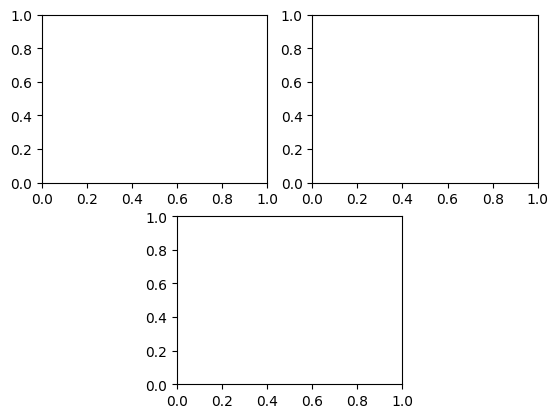

In [227]:


plt.show()

In [52]:
# def graficar_un_sujeto(df, SUJ_NUM, TRIAL_NUM, RADIUS=18, CANVAS_SIZE=750):
#         # Style
#         COLORMAP_traj = "inferno"
#         plt.style.use("seaborn")
#         plt.rcParams["image.cmap"] = COLORMAP_traj
#         # plt.rcParams['font.size'] = 1
#         sns.set(font_scale=1.5)

#         # Tamanio del grafico
#         _, axs = plt.subplots(figsize=(12, 12))

#         # #Settings para ploteo de items

#         # Position fo the items presented on screen

#         circle_coords = eval(df["all_xy_data"][SUJ_NUM])[TRIAL_NUM]  # Posicion de items
#         stim_content = eval(df["all_content_data"][SUJ_NUM])[
#             TRIAL_NUM
#         ]  # Contenido de los items
#         # diccionario_items = dict(zip(circle_coords,stim_content))
#         CIRCLE_RADIUS = RADIUS
#         FONT_SIZE = 14

#         g2 = plt.scatter(
#             x=eval(df["x_y_first_click"][SUJ_NUM])[TRIAL_NUM][0],
#             y=eval(df["x_y_first_click"][SUJ_NUM])[TRIAL_NUM][1],
#             color="g",
#             edgecolors="yellow",
#             marker="o",
#             s=100,
#             zorder=1000,
#         )

#         for stim_iterator, i in enumerate(circle_coords):

#             a_circle = plt.Circle(i, CIRCLE_RADIUS, zorder=190)

#             axs.add_artist(a_circle)

#             axs.add_patch(a_circle)

#             label = axs.annotate(
#                 stim_content[stim_iterator],
#                 xy=i,
#                 fontsize=FONT_SIZE,
#                 horizontalalignment="center",
#                 verticalalignment="center",
#                 color="white",
#                 zorder=200,
#             )

#         # Grafico la trayectoria
#         g = sns.scatterplot(
#             x=eval(df["x"][SUJ_NUM])[TRIAL_NUM],
#             y=eval(df["y"][SUJ_NUM])[TRIAL_NUM],
#             c=eval(df["t"][SUJ_NUM])[TRIAL_NUM],
#             cmap=COLORMAP_traj,
#             zorder=10,
#         )  # z-order sirve para seleccionar la capa donde se plote (por delante o por detras de las otras cosas)

#         # Aca invierto los ejes porque en mi experimento el (0,0) es la esquina superior izquierda
#         g = plt.gca()  # get the axis
#         g.set_ylim(g.get_ylim()[::-1])  # invert the axis
#         g.xaxis.tick_top()  # and move the X-Axis

#         # Set axis
#         g.set_xlim(0, CANVAS_SIZE)  # set the ylim to left, right
#         g.set_ylim(CANVAS_SIZE, 0)  # set the xlim to left, right

#         # Grafico los puntos que tocan los circulos
#         g3 = plt.scatter(
#             x=eval(df["within_circle_x"][SUJ_NUM])[TRIAL_NUM],
#             y=eval(df["within_circle_y"][SUJ_NUM])[TRIAL_NUM],
#             color="red",
#             edgecolors="red",
#             marker="o",
#             s=20,
#             zorder=500,
#         )

#         # Labels
#         g.set(
#             xlabel="x coordinate",
#             ylabel="y coordinate",
#             title=f"Trayectoria del mouse en la pantalla para el sujetx {SUJ_NUM} trial {TRIAL_NUM} \n",
#         )

#         plt.colorbar(label="Time", orientation="horizontal", pad=0.001)

#         plt.show

In [ ]:
# Style
COLORMAP_traj = "inferno"
plt.style.use("seaborn")
plt.rcParams["image.cmap"] = COLORMAP_traj
sns.set(font_scale=1.5)

# Tamanio del grafico
_, axs = plt.subplots(figsize=(12, 12))


# plots 

CIRCLE_RADIUS = 10
circle_coords = []

for stim_iterator, i in enumerate(circle_coords):

    a_circle = plt.Circle(i, CIRCLE_RADIUS, zorder=190)
    axs.add_artist(a_circle)
    axs.add_patch(a_circle)